In [1]:
#topology tester...
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import lax
import jaxkd as jk 

import jax
import jax.numpy as jnp
from jax import lax
import jaxkd as jk

LOGIT_CLIP = 30.0
MASK_LOGIT = -30.0

def _ensure_xyz32(pos):
    pos = jnp.asarray(pos)
    pos = pos.astype(jnp.float32, copy=False)
    assert pos.ndim == 2
    N, D = pos.shape
    if D == 3: return pos
    if D == 2: return jnp.concatenate([pos, jnp.zeros((N,1), pos.dtype)], 1)
    raise ValueError("pos must be (N,2) or (N,3)")

def _knn_neighbors(pos32, k, cuda=False):
    tree = jk.build_tree(pos32, cuda=cuda)
    nbr_idx, _ = jk.query_neighbors(tree, pos32, k=k, cuda=cuda)
    return nbr_idx  # [N,k], may contain -1

def _edge_logits_from_knn(pos32, nbr_idx, b, alpha):
    N, k = nbr_idx.shape
    i = jnp.repeat(jnp.arange(N, dtype=jnp.int32), k)
    j = nbr_idx.reshape(-1)
    valid = (j >= 0)
    j_safe = jnp.where(valid, j, 0)
    diff = pos32[i] - pos32[j_safe]
    d2   = jnp.sum(diff * diff, axis=1)                 # squared distance
    b2   = jnp.asarray(b, pos32.dtype)**2
    z    = alpha * (b2 - d2) / (jnp.abs(b2) + 1e-12)
    z    = jnp.where(valid, z, MASK_LOGIT)
    return jnp.clip(z, -LOGIT_CLIP, LOGIT_CLIP)         # [N*k]

def _bernoulli_logpmf(logits, y):
    z = logits; y = y.astype(z.dtype)
    return y * (-jax.nn.softplus(-z)) + (1 - y) * (-jax.nn.softplus(z))

def _cc_label_prop_dense_masked_stochastic(pos32, nbr_idx, b, max_iters, edge_on_flat):
    N, k = nbr_idx.shape
    labels0 = jnp.arange(N, dtype=jnp.int32)
    i   = jnp.arange(N, dtype=jnp.int32)
    src = jnp.repeat(i, k)
    dst = nbr_idx.reshape(-1)

    dst_ge0   = (dst >= 0)
    non_self  = (src != jnp.where(dst_ge0, dst, 0))
    valid_idx = dst_ge0 & non_self
    dst_safe  = jnp.where(dst_ge0, dst, 0)

    d  = pos32[src] - pos32[dst_safe]
    b2 = jnp.asarray(b, pos32.dtype)**2
    within = jnp.sum(d * d, axis=1) <= b2

    edge_on = (edge_on_flat > 0)
    valid = valid_idx & within & edge_on

    big = jnp.int32(N)
    def one_iter(labels):
        incoming = jnp.full((N,), big, dtype=jnp.int32)
        incoming = incoming.at[dst_safe].min(jnp.where(valid, labels[src], big))
        incoming = incoming.at[src].min(jnp.where(valid, labels[dst_safe], big))
        return jnp.minimum(labels, incoming)

    return lax.fori_loop(0, max_iters, lambda _, lab: one_iter(lab), labels0)

def _effective_halo_count(labels, min_mass=1.0, weights=None):
    """
    Count halos whose total mass >= min_mass. JIT/vmap-safe (static-N accumulators).
    """
    N = labels.shape[0]
    w = jnp.ones((N,), jnp.float32) if weights is None else weights.astype(jnp.float32)

    K = jnp.max(labels) + 1
    idx = jnp.arange(N, dtype=jnp.int32)
    in_range = (idx < K)                         # which label ids are real

    mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
        jnp.where(labels >= 0, w, 0.0)
    )                                            # [N] mass per potential halo id

    keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
    return jnp.sum(keep_full).astype(jnp.float32)  # scalar

def one_sample_terms_positions(key, pos_params, *,
                               b, alpha, k, max_iters,
                               min_mass=1.0, weights=None, cuda=False,
                               sign=+1):
    """
    sign=+1 -> minimize #halos; sign=-1 -> maximize #halos
    pos_params: [N,2/3] are the *trainable* particle positions
    """
    pos32   = _ensure_xyz32(pos_params)
    nbr_idx = _knn_neighbors(pos32, k, cuda=cuda)

    logits = _edge_logits_from_knn(pos32, nbr_idx, b, alpha)  # [N*k]
    probs  = jax.nn.sigmoid(logits)
    y      = jax.random.bernoulli(key, p=probs).astype(jnp.int32)

    logp   = jnp.sum(_bernoulli_logpmf(logits, y))            # scalar
    labels = _cc_label_prop_dense_masked_stochastic(pos32, nbr_idx, b, max_iters, y)

    K_eff  = _effective_halo_count(labels, min_mass=min_mass, weights=weights)
    L      = sign * K_eff                                     # minimize or maximize
    return L, logp

def loss_and_grad_positions(pos_params, key, *,
                            b, alpha=5.0, k=16, max_iters=50,
                            min_mass=1.0, weights=None,
                            S=16, cuda=False, sign=+1,
                            normalize_adv=True, clip_adv=10.0):
    """
    Returns (mean_K_eff * sign, grad wrt pos_params).
    """
    keys = jax.random.split(key, S)

    def batch_objective(pp):
        Ls, logps = jax.vmap(lambda kk: one_sample_terms_positions(
            kk, pp, b=b, alpha=alpha, k=k, max_iters=max_iters,
            min_mass=min_mass, weights=weights, cuda=cuda, sign=sign))(keys)
        baseline = jnp.mean(Ls)                         # per-batch mean baseline
        adv = jax.lax.stop_gradient(Ls - baseline)
        if normalize_adv:
            adv = (adv - jnp.mean(adv)) / (jnp.std(adv) + 1e-8)
        if clip_adv is not None:
            adv = jnp.clip(adv, -clip_adv, clip_adv)

        J_samples = Ls + adv * logps                   # per-sample surrogate
        return jnp.mean(J_samples), jnp.mean(Ls)       # (value, aux)

    (J_mean, L_mean), g = jax.value_and_grad(lambda pp: batch_objective(pp),
                                             has_aux=True)(pos_params)
    return L_mean, g

In [2]:
import fof.fofkd as fof

def _effective_halo_count(labels, min_mass=1.0, weights=None):
    """Count halos whose mass >= min_mass. Uses static-N buffers (JIT/vmap-safe)."""
    N = labels.shape[0]
    w = jnp.ones((N,), jnp.float32) if weights is None else weights.astype(jnp.float32)

    K = jnp.max(labels) + 1
    idx = jnp.arange(N, dtype=jnp.int32)
    in_range = (idx < K)

    mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
        jnp.where(labels >= 0, w, 0.0)
    )
    keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
    return jnp.sum(keep_full).astype(jnp.float32)  # scalar


def count_halos_deterministic(pos, b, k, max_iters, min_mass=1.0, cuda=False, weights=None):
    pos32 = _ensure_xyz32(pos)
    # Your existing hard FoF:
    labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos32, b=b, k=k, max_iters=max_iters, cuda=cuda)
    # Count with min-mass; labels are already 0..K-1
    return _effective_halo_count(labels, min_mass=min_mass, weights=weights)

    

In [3]:
# Example: random init, then push positions to change halo count
key = jax.random.PRNGKey(0)
N = 1_000
pos0 = jax.random.uniform(key, (N, 2), minval=0.0, maxval=1.0).astype(jnp.float32)*4

# FoF params
b = 0.1          # linking length (box units)
k = 16
alpha = 5.0       # keep modest; anneal up later if desired
max_iters = 100
min_mass = 4     # e.g. only count halos with >=10 particles

# Choose objective: minimize or maximize number of halos
sign = -1         # +1: minimize,  -1: maximize


In [4]:
count_halos_deterministic(pos0,b,k,max_iters,min_mass)

Array(85., dtype=float32)

In [5]:
pos_i = pos0
for i in range(0,100):
    # One gradient step on positions
    L, gpos = loss_and_grad_positions(
        pos_i, jax.random.PRNGKey(42),
        b=b, alpha=alpha, k=k, max_iters=max_iters,
        min_mass=min_mass, S=32, sign=sign, cuda=False,
        normalize_adv=True, clip_adv=10.0
    )
    
    # Simple SGD step 
    lr = 3e-4
    pos_i = pos_i - lr * gpos
    print(i,count_halos_deterministic(pos_i,b,k,max_iters,min_mass),)

0 90.0
1 100.0
2 100.0
3 102.0
4 101.0
5 102.0
6 101.0
7 99.0
8 102.0
9 104.0
10 106.0
11 106.0
12 108.0
13 106.0
14 107.0
15 108.0
16 105.0
17 102.0
18 106.0
19 108.0
20 110.0
21 108.0
22 115.0
23 111.0
24 113.0
25 113.0
26 111.0
27 113.0
28 114.0
29 114.0
30 114.0
31 112.0
32 115.0
33 113.0
34 116.0
35 115.0
36 117.0
37 114.0
38 117.0
39 121.0
40 112.0
41 115.0
42 117.0
43 120.0
44 118.0
45 123.0
46 123.0
47 122.0
48 121.0
49 125.0
50 124.0
51 123.0
52 123.0
53 126.0
54 123.0
55 122.0
56 124.0
57 125.0
58 128.0
59 127.0
60 128.0
61 128.0
62 125.0
63 126.0
64 124.0
65 123.0
66 120.0
67 121.0
68 125.0
69 120.0
70 120.0
71 122.0
72 122.0
73 122.0
74 122.0
75 123.0
76 123.0
77 123.0
78 125.0
79 125.0
80 126.0
81 126.0
82 128.0
83 126.0
84 129.0
85 129.0
86 128.0
87 128.0
88 129.0
89 129.0
90 129.0
91 131.0
92 129.0
93 128.0
94 127.0
95 129.0
96 130.0
97 131.0
98 130.0
99 129.0


In [6]:
labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos_i, b=b, k=k, max_iters=max_iters, cuda=False)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/fof/lib/python3.13/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['sign']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


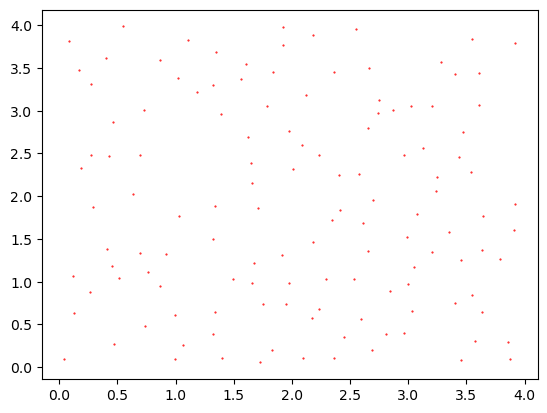

In [7]:
%pylab inline
N = labels.shape[0]

K = jnp.max(labels) + 1
idx = jnp.arange(N, dtype=jnp.int32)
in_range = (idx < K)

mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
    jnp.where(labels >= 0, 1.0, 0.0)
)
keep_full_i = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))

plt.plot(pos_i[:,0][keep_full_i],pos_i[:,1][keep_full_i],"r.",markersize=1)

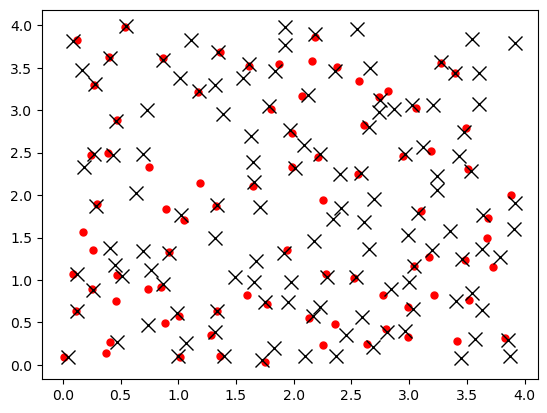

In [8]:
labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos0, b=b, k=k, max_iters=max_iters, cuda=False)

N = labels.shape[0]

K = jnp.max(labels) + 1
idx = jnp.arange(N, dtype=jnp.int32)
in_range = (idx < K)

mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
    jnp.where(labels >= 0, 1.0, 0.0)
)
keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
plt.plot(pos0[:,0][keep_full],pos0[:,1][keep_full],"r.",markersize=10)
plt.plot(pos_i[:,0][keep_full_i],pos_i[:,1][keep_full_i],"kx",markersize=10)

In [ ]:
#yay more Xs

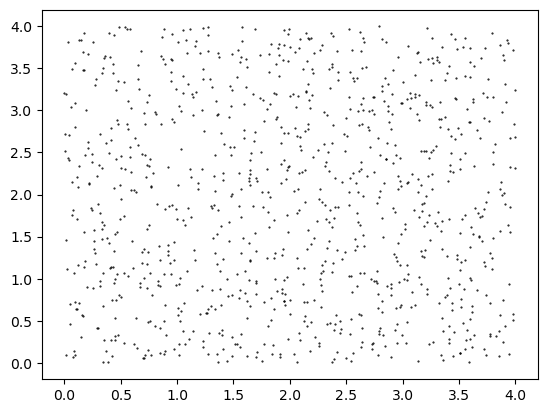

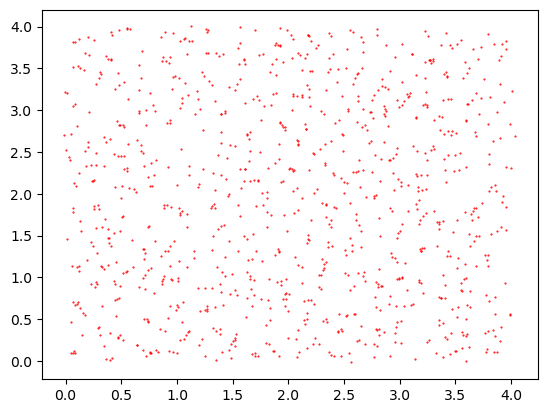

In [9]:
plt.plot(pos0[:,0],pos0[:,1],"k.",markersize=1)
plt.show()
plt.plot(pos_i[:,0],pos_i[:,1],"r.",markersize=1)

In [ ]:
#red looks a bit more clustered! yay!

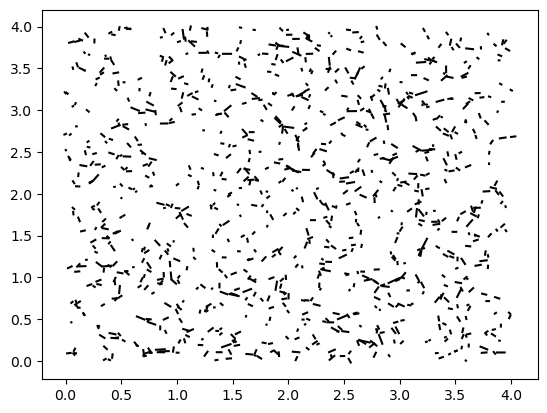

In [10]:
for i in range(0,1000):
    plt.plot([pos0[i,0],pos_i[i,0]],[pos0[i,1],pos_i[i,1]],"k",markersize=1)

plt.show()

In [ ]:
#lots of movement to form clusters! :D 